# Pipelines

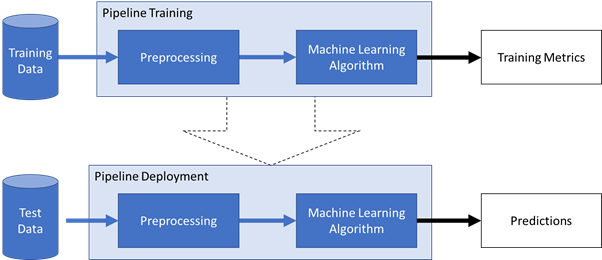

Each step applied to the training data must also be applied to the test data, using the same parameters, such as the standard deviation calculated during the pre-processing step. Using the Pipeline function within scikit-learn, each pre-processing transformer can be bundled into a single object, along with the final estimator, allowing the entire process to be trained as one on incoming data, and leveraged to predict values based on new data.

As well as common hyperparameters, there are discovered parameters from the dataset which need to be transferred across to incoming data. For example scaling based on the mean and standard deviation of the training dataset.
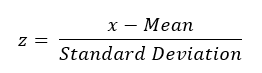

In [56]:
import pandas as pd

In [57]:
# Import Training Data
data = pd.read_csv("train_selected.csv")
y_train = data["label_bnc"]
X_train = data[["cycle","s1","s2","s3","s4"]]

# Import validation data
X_val = pd.read_csv("test_selected.csv")
X_val.pop('id')      # Don't include engine ID
y_val = [int(int(line)<=30) for line in open("PM_truth.txt", "r").readlines()]

In [58]:
X_train.head()

,cycle,s1,s2,s3,s4
0,1,1400.60,554.36,47.47,521.66
1,2,1403.14,553.75,47.49,522.28
2,3,1404.20,554.26,47.27,522.42
3,4,1401.87,554.45,47.13,522.86
4,5,1406.22,554.00,47.28,522.19


In [59]:
X_train.describe()

,cycle,s1,s2,s3,s4
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,108.807862,1408.933782,553.367711,47.541168,521.413470
std,68.880990,9.000605,0.885092,0.267087,0.737553
min,1.000000,1382.250000,549.850000,46.850000,518.690000
25%,52.000000,1402.360000,552.810000,47.350000,520.960000
50%,104.000000,1408.040000,553.440000,47.510000,521.480000
75%,156.000000,1414.555000,554.010000,47.700000,521.950000
max,362.000000,1441.490000,556.060000,48.530000,523.380000


Example data is a simplified subset of NASA's Turbofan data set for predictive maintenance. The task is to predict whether an engine is in its final 30 useful cycles.

In [60]:
import matplotlib.pyplot as plt

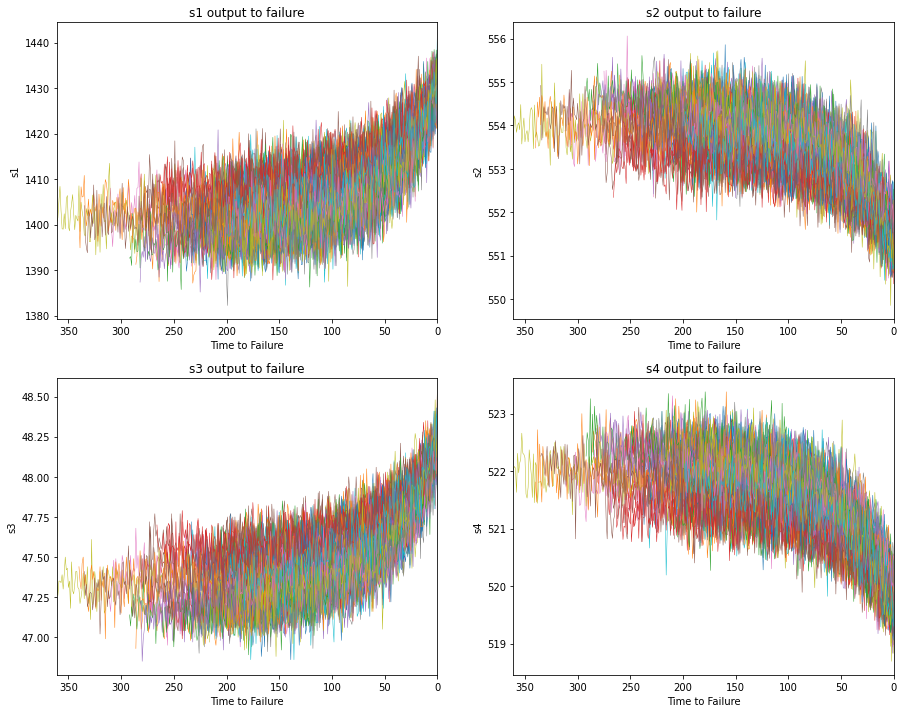

In [61]:
ttf_max = data["ttf"].max()  # Maximum time to failure
ttf_min = data["ttf"].min()  # Minimum time to failure

f, a = plt.subplots(2, 2, figsize=(15,12))   # Set subplots
sensors = ["s1", "s2", "s3", "s4"]
axes = [a[0][0], a[0][1], a[1][0], a[1][1]]
for ax, s in zip(axes, sensors):             # Iterate through two lists together
    for engine, group in data.groupby("id"):            
        ax.plot(group["ttf"],                # X-axis (TTF)
                group[s],                    # Y-axis (Sensor data)
                linewidth=0.5)
    ax.set_xlabel("Time to Failure")
    ax.set_ylabel(str(s)) 
    ax.set_xlim(ttf_max,ttf_min)            # Invert X-axis
    ax.set_title("{} output to failure".format(s))
plt.show()

In [62]:
import seaborn as sns

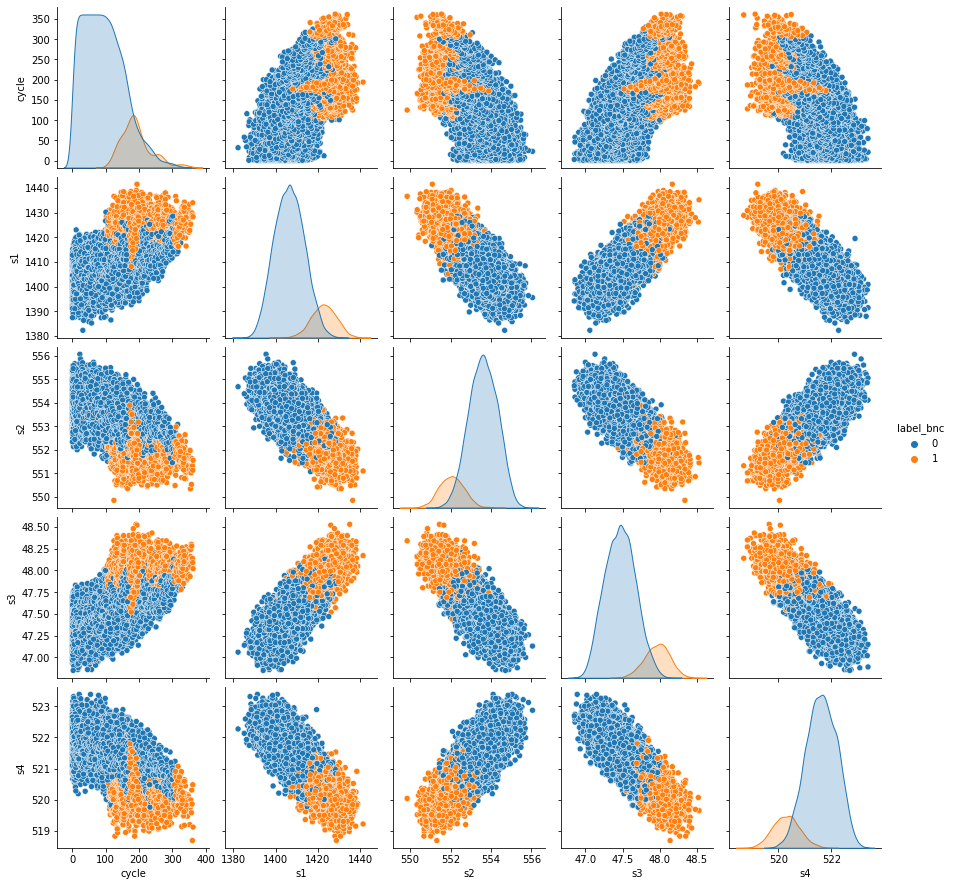

In [63]:
sns.pairplot(data[["cycle","s1","s2","s3","s4","label_bnc"]], hue = "label_bnc")

# Establish Pipeline

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

In [65]:
pipeline = Pipeline([
    # Preprocessing
    ('pfs', PolynomialFeatures()),   # Calculate polynomial relationships in data
    ('ss', StandardScaler()),        # Scale and centre
    ('pca', PCA()),                  # Reduce dimensionality
    # Estimator
    ('log', LogisticRegression()),   # Chosen for this demo for performance / speed
    ])

In [66]:
for step in pipeline: print(step)

PolynomialFeatures()
StandardScaler()
PCA()
LogisticRegression()


# Treat Pipeline as Model

In [71]:
def resultplot(model,name):
    
    pred_val = model.predict(X_val)                                   # Get predictions 
    print(metrics.classification_report(y_val,pred_val))              # Print standard report
    
    f, (ax1,ax2) = plt.subplots(ncols=2,                              # Establish double plot
                               figsize=(20,5),                        # Overall figure size
                                gridspec_kw={'width_ratios': [3, 1]}) # Space assignment
    y = [int(line) for line in open("PM_truth.txt", "r").readlines()] 
    x = range(0,len(y))
    recall = metrics.recall_score(y_val,pred_val,average='binary')
    df = pd.DataFrame(list(zip(y,pred_val)),                          # Format 
                      columns=["ttf","label_bnc"]).sort_values(by="ttf")
    df["x"] = range(0,len(y))
    for lname, group in df.groupby("label_bnc"):
        ax1.scatter(group["x"],group["ttf"],label=lname)              #Plot by category
    ax1.legend()
    ax1.set_ylabel("Time to Failure")
    ax1.set_title("Classification results: {}\n Weighted Recall: {}".format(name, recall))
    ax1.hlines(y = 30, xmin = 0, xmax = max(x))
    ax1.axes.xaxis.set_visible(False)
    ax1 = plt.gca() 

    matrix = pd.DataFrame(metrics.confusion_matrix(y_val,pred_val),
                      index=[0,1],
                      columns=[0,1])
    ax2 = sns.heatmap(matrix, annot=True, fmt="d", cmap="rocket_r")
    ax2.yaxis.set_ticklabels(ax2.yaxis.get_ticklabels(), 
                             rotation=0, ha='right', 
                             fontsize=14)
    ax2.xaxis.set_ticklabels(ax2.xaxis.get_ticklabels(), 
                             rotation=0, ha='right', 
                             fontsize=14)
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    plt.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.89      0.68      0.77        25

    accuracy                           0.90       100
   macro avg       0.90      0.83      0.85       100
weighted avg       0.90      0.90      0.90       100



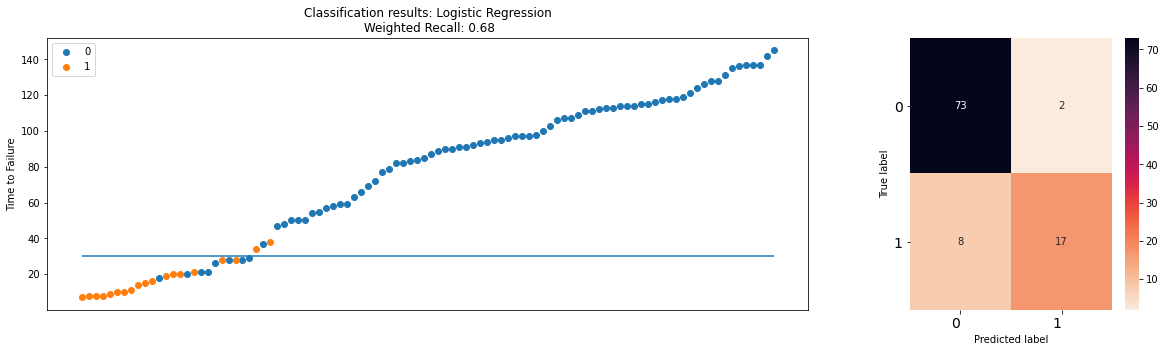

In [72]:
pipeline.fit(X_train, y_train)                          # Fit all pipeline elements to training data

predictions = pipeline.predict(X_val)                   # Predict results of validation data

resultplot(pipeline,"Logistic Regression")              # Show results

# Establish Grid parameters

The majority of transformers and estimators have multiple options to determine the exact nature of the transformation, or tools and hyperparameters used for prediction. In many cases the ideal setting is dependent on other settings, making finding the optimum combination nontrivial. For this exercise, a gridsearch approach was adopted, wherein all hyperparameter settings of interest are supplied for a transformer or estimator, and all possible combinations are tested for suitability. This is a particularly powerful tool in combination with Pipelines, allowing the parameters to all transformers and estimators to be investigated simultaneously. 

As all combinations are tried, the number of investigations required increases geometrically with the parameters to be investigated, placing a de facto upper limit on the scope of the investigation based on available processor time. 

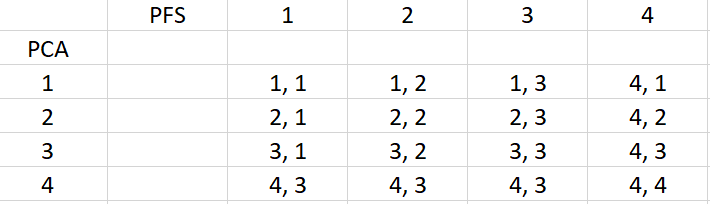

Where processor time is a limiting factor, RandomSearch can be used instead of GridSearch - generates all combinations and then tests _n_ of them, rather than all.

Where parameters are stated for entire pipelines, prefixing the parameter with the relevant pipeline step name (as defined in the 'establish pipeline' stage and two underscores establishes where to assign the parameter. For example, figures assigned to 'pfs__degree' will be used as 'degree' parameters in the 'pfs' step.

In [73]:
params = {
    'pfs__degree':(1,2,3,4, 5),                    # Degree of polynomials to explore
    'pca__n_components': (2,3,4,5),             # PCA output dimensionality
    'log__class_weight':(None,'balanced'),      # Whether to weight samples by representation
    'log__solver':('lbfgs','liblinear','sag')   # Solver used by estimator
    }

# Establish Gridsearch and Train

Note - Cross Validation is part of the default deployment of a Gridsearch. Each combination is fitted _k_ times, and then the combination with the highest score is retrained on the full dataset. (_k_ = 5 by default)

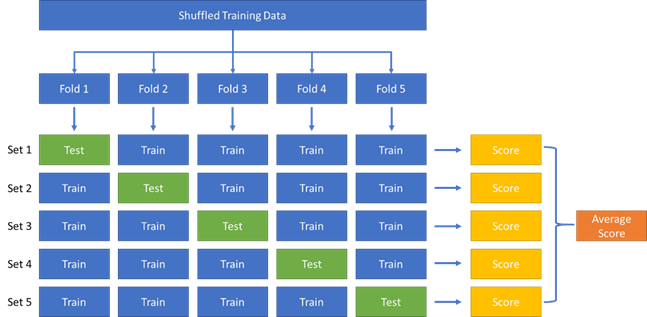

Note that this greatly increases the training needed. 96 parameter combinations becomes 480 fits.

In [74]:
from sklearn.model_selection import GridSearchCV

In [75]:
roc_auc = metrics.make_scorer(metrics.roc_auc_score)    # Establish metric for 'best'

grid = GridSearchCV(pipeline,       # Import pipeline established earlier
                    params,         # Import parameters for gridsearch
                    verbose=10,     # Level of data to output to console (0-50)
                    n_jobs=-1,      # Number of processors to use (-1 = all)
                    scoring=roc_auc # How to define 'best' model
                   )

grid.fit(X_train,y_train)           # Begin fitting of all models

print("Best performing model achieved area under ROC curve: {}".format(grid.best_score_))
model = grid.best_estimator_        # Outputs best performance
print(model)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best performing model achieved area under ROC curve: 0.9276733710320741
Pipeline(steps=[('pfs', PolynomialFeatures(degree=4)), ('ss', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('log', LogisticRegression(class_weight='balanced'))])


# Results

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        75
           1       0.74      0.80      0.77        25

    accuracy                           0.88       100
   macro avg       0.84      0.85      0.84       100
weighted avg       0.88      0.88      0.88       100



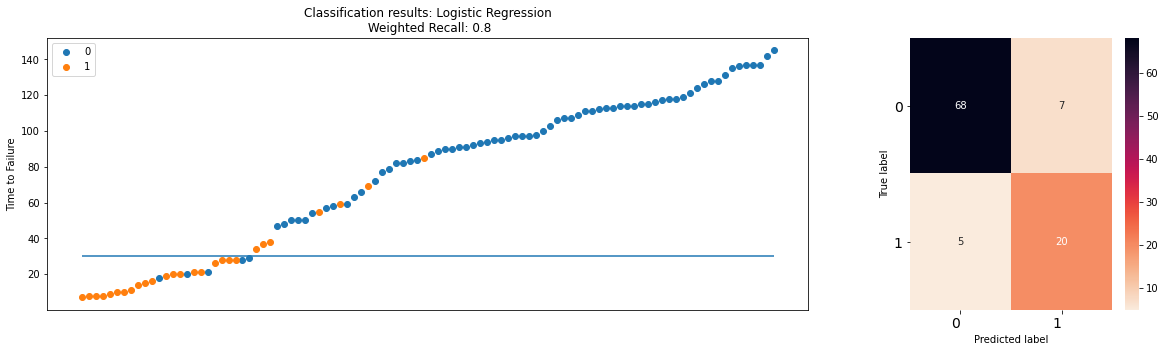

In [76]:
resultplot(model,"Logistic Regression")

In [77]:
results = pd.DataFrame.from_dict(grid.cv_results_) # cv_results_ attribute of grid gives full results
results.sort_values(by="rank_test_score").head(10)   # Sort by best performance, print top 10

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__class_weight,param_log__solver,param_pca__n_components,param_pfs__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
95,1.860131,0.134057,0.069883,0.012441,balanced,sag,5,4,"{'log__class_weight': 'balanced', 'log__solver...",0.931774,0.939666,0.926360,0.917566,0.923001,0.927673,0.007568,1
63,1.737565,0.029430,0.072319,0.002168,balanced,lbfgs,5,4,"{'log__class_weight': 'balanced', 'log__solver...",0.931774,0.939666,0.926360,0.917566,0.923001,0.927673,0.007568,1
79,1.688531,0.039810,0.071616,0.003153,balanced,liblinear,5,4,"{'log__class_weight': 'balanced', 'log__solver...",0.931774,0.939096,0.926218,0.917566,0.923001,0.927531,0.007393,3
53,0.469545,0.015776,0.029963,0.002388,balanced,lbfgs,3,2,"{'log__class_weight': 'balanced', 'log__solver...",0.928690,0.935634,0.914082,0.915806,0.918865,0.922615,0.008242,4
85,0.606848,0.014607,0.029627,0.002875,balanced,sag,3,2,"{'log__class_weight': 'balanced', 'log__solver...",0.928690,0.935634,0.914082,0.915806,0.918865,0.922615,0.008242,4
69,0.432886,0.017232,0.030966,0.001530,balanced,liblinear,3,2,"{'log__class_weight': 'balanced', 'log__solver...",0.928405,0.935634,0.913939,0.915663,0.918722,0.922473,0.008266,6
73,0.480242,0.031584,0.032041,0.002895,balanced,liblinear,4,2,"{'log__class_weight': 'balanced', 'log__solver...",0.926792,0.936155,0.915410,0.915663,0.918058,0.922416,0.008020,7
59,1.659038,0.033211,0.068842,0.001930,balanced,lbfgs,4,4,"{'log__class_weight': 'balanced', 'log__solver...",0.926935,0.937104,0.911377,0.916755,0.918772,0.922188,0.008979,8
91,1.786801,0.050272,0.067154,0.004747,balanced,sag,4,4,"{'log__class_weight': 'balanced', 'log__solver...",0.926935,0.937104,0.911377,0.916755,0.918772,0.922188,0.008979,8
89,0.669883,0.009927,0.032391,0.004833,balanced,sag,4,2,"{'log__class_weight': 'balanced', 'log__solver...",0.926792,0.936298,0.914746,0.915806,0.917252,0.922179,0.008256,10


# Export full results to Excel

In [78]:
results.to_excel("LogSearch.xlsx")   